# 4. Modelagem Supervisionada e Avaliação - Tech Challenge Fase 3

Neste notebook final, treinaremos modelos para prever atrasos e avaliaremos seus desempenhos.

**Objetivos:**
1. Dividir dados em Treino e Teste.
2. Treinar modelos de Classificação (Logística vs Random Forest).
3. Avaliar métricas (Acurácia, Recall, Matriz de Confusão).
4. Diagnosticar o modelo (Feature Importance).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

## 1. Carga e Separação (Treino/Teste)

In [2]:
try:
    df = pd.read_csv('flights_ml_ready.csv')
    print(f"Dataset carregado! Shape: {df.shape}")
except FileNotFoundError:
    print("ERRO: Arquivo 'flights_ml_ready.csv' não encontrado.")

# Separando X e y
# Vamos remover a variável alvo 'IS_DELAYED' e também 'ARRIVAL_DELAY' (que é a resposta da regressão)
X = df.drop(['IS_DELAYED', 'ARRIVAL_DELAY'], axis=1)
y = df['IS_DELAYED']

# Split 70/30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"Treino: {X_train.shape}, Teste: {X_test.shape}")
print("Proporção de atrasos no treino:")
print(y_train.value_counts(normalize=True))

Dataset carregado! Shape: (100000, 12)
Treino: (70000, 10), Teste: (30000, 10)
Proporção de atrasos no treino:
IS_DELAYED
0   0.82
1   0.18
Name: proportion, dtype: float64


## 2. Treinamento de Modelos (Classificação)

Vamos comparar:
1. **Regressão Logística:** Modelo linear simples (Baseline).
2. **Random Forest:** Modelo de ensemble (Árvores), geralmente mais robusto.

In [3]:
# Modelo 1: Regressão Logística
print("Treinando Regressão Logística...")
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train, y_train)

# Predições
y_pred_logreg = logreg.predict(X_test)
y_prob_logreg = logreg.predict_proba(X_test)[:, 1]

print("Concluído!")

Treinando Regressão Logística...
Concluído!


In [4]:
# Modelo 2: Random Forest
print("Treinando Random Forest (pode demorar um pouco)...")
# Limitando max_depth para não demorar demais e evitar overfitting extremo
rf = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

# Predições
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

print("Concluído!")

Treinando Random Forest (pode demorar um pouco)...
Concluído!


## 3. Avaliação e Comparação
Vamos olhar as métricas principais. Para previsão de atraso, o **Recall** (capturar quem vai atrasar) geralmente é mais importante que a Acurácia pura.

In [5]:
print("=== Performance: Regressão Logística ===")
print(classification_report(y_test, y_pred_logreg))
print(f"AUC-ROC: {roc_auc_score(y_test, y_prob_logreg):.4f}")

print("\n=== Performance: Random Forest ===")
print(classification_report(y_test, y_pred_rf))
print(f"AUC-ROC: {roc_auc_score(y_test, y_prob_rf):.4f}")

=== Performance: Regressão Logística ===
              precision    recall  f1-score   support

           0       0.94      0.98      0.96     24662
           1       0.89      0.71      0.79      5338

    accuracy                           0.93     30000
   macro avg       0.92      0.85      0.88     30000
weighted avg       0.93      0.93      0.93     30000

AUC-ROC: 0.9278

=== Performance: Random Forest ===
              precision    recall  f1-score   support

           0       0.94      0.98      0.96     24662
           1       0.90      0.71      0.79      5338

    accuracy                           0.93     30000
   macro avg       0.92      0.84      0.88     30000
weighted avg       0.93      0.93      0.93     30000

AUC-ROC: 0.9336


### Matriz de Confusão Visual
Para entender ONDE o modelo está errando (Falsos Positivos vs Falsos Negativos).

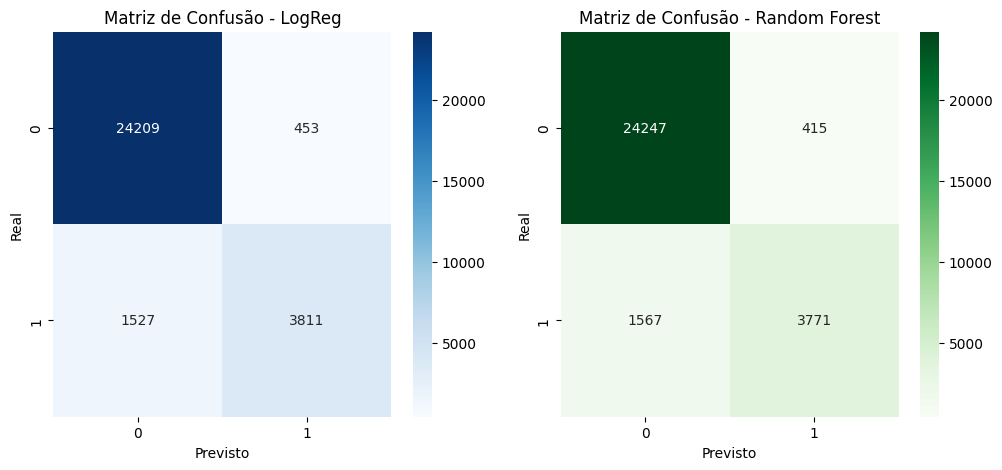

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(confusion_matrix(y_test, y_pred_logreg), annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title('Matriz de Confusão - LogReg')
ax[0].set_xlabel('Previsto')
ax[0].set_ylabel('Real')

sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Greens', ax=ax[1])
ax[1].set_title('Matriz de Confusão - Random Forest')
ax[1].set_xlabel('Previsto')
ax[1].set_ylabel('Real')

plt.show()

## 4. Diagnóstico: Feature Importance
Quais variáveis o Random Forest considerou mais importantes para decidir se um voo vai atrasar?

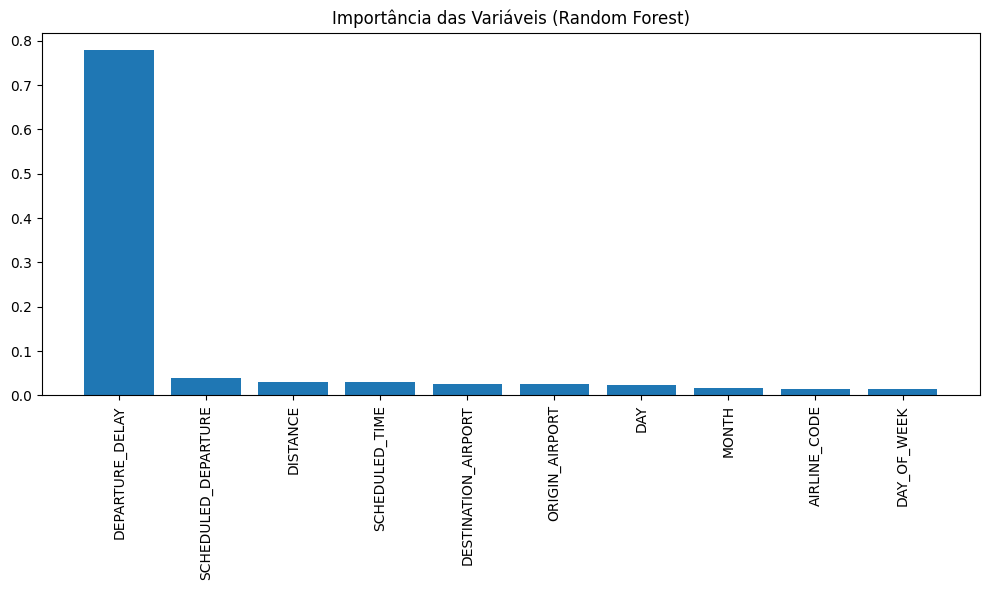

In [7]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
features = X.columns

plt.figure(figsize=(10, 6))
plt.title("Importância das Variáveis (Random Forest)")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), features[indices], rotation=90)
plt.tight_layout()
plt.show()

## 5. Conclusões Finais

Escreva aqui suas conclusões finais sobre o projeto.

**Exemplo:**
- O modelo Random Forest superou a Regressão Logística.
- A variável `DEPARTURE_DELAY` (atraso na saída) é o maior preditor do atraso na chegada (o que é esperado).
- Fatores como distância e dia da semana têm impacto menor, mas existem.
- Para produção, recomendaria usar o Random Forest.